<a href="https://colab.research.google.com/github/HassanCoulibaly/MachineLearningProject/blob/side/Multiple_CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ✅ Full Implementation of Model 6: Multiple CNNs + LSTM for Twitter Sentiment Analysis

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [13]:

# 1. Load Dataset
train_df = pd.read_csv('dataset/train_df.csv')
test_df = pd.read_csv('dataset/test_df.csv')



In [14]:
# 2. Preprocess Text and Labels
vocab_size = 10000
max_length = 40
embedding_dim = 50

label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])
y_train = tf.keras.utils.to_categorical(label_encoder.transform(train_df['sentiment']), num_classes=3)
y_test = tf.keras.utils.to_categorical(label_encoder.transform(test_df['sentiment']), num_classes=3)

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['tweet'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['tweet']), maxlen=max_length, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['tweet']), maxlen=max_length, padding='post')



In [15]:
# 3. Load GloVe Embeddings
glove_path = 'dataset/glove.6B.50d.txt'
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



In [17]:
# 4. Build Model 6: Multi-CNN + LSTM
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], trainable=False)(input_layer)

cnn_3 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(embedding_layer)
cnn_4 = Conv1D(64, kernel_size=4, padding='same', activation='relu')(embedding_layer)
cnn_5 = Conv1D(64, kernel_size=5, padding='same', activation='relu')(embedding_layer)

pool_3 = MaxPooling1D(pool_size=2, padding='same')(cnn_3)
pool_4 = MaxPooling1D(pool_size=2, padding='same')(cnn_4)
pool_5 = MaxPooling1D(pool_size=2, padding='same')(cnn_5)

merged = Concatenate(axis=-1)([pool_3, pool_4, pool_5])
lstm_out = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(merged)
output = Dense(3, activation='softmax')(lstm_out)

model6 = Model(inputs=input_layer, outputs=output)
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 40, 50)    │    500,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 40, 64)    │      9,664 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 40, 64)    │     12,864 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 40, 64)    │     16,064 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 20, 64)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 20, 64)    │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 20, 64)    │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 20, 192)   │          0 │ max_pooling1d_9[… │
│ (Concatenate)       │                   │            │ max_pooling1d_10… │
│                     │                   │            │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     65,792 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        195 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 604,579 (2.31 MB)

 Trainable params: 104,579 (408.51 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [18]:
# 5. Train Model
history6 = model6.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 89s 50ms/step - accuracy: 0.5279 - loss: 0.9311 - val_accuracy: 0.6093 - val_loss: 0.8469
Epoch 2/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 139s 48ms/step - accuracy: 0.6206 - loss: 0.8101 - val_accuracy: 0.6143 - val_loss: 0.8425
Epoch 3/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.6469 - loss: 0.7684 - val_accuracy: 0.6078 - val_loss: 0.8561
Epoch 4/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.6626 - loss: 0.7387 - val_accuracy: 0.6042 - val_loss: 0.8540
Epoch 5/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.6785 - loss: 0.7131 - val_accuracy: 0.6161 - val_loss: 0.8419
Epoch 6/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.6872 - loss: 0.6924 - val_accuracy: 0.6178 - val_loss: 0.8557
Epoch 7/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.7052 - loss: 0.6613 - val_accuracy: 0.6057 - val_loss: 0.8721
Epoch 8/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - accuracy: 0.7181 

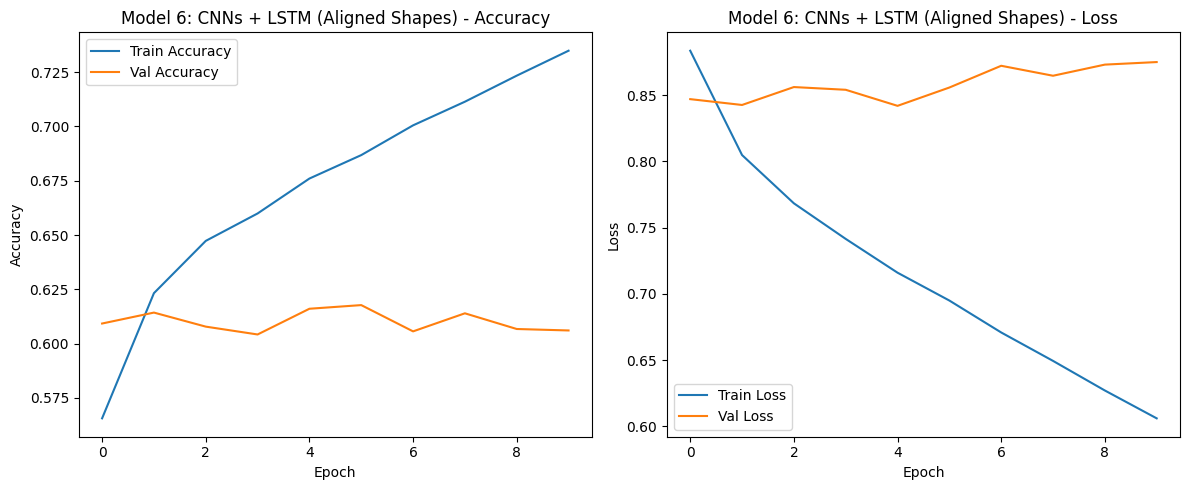

In [19]:
# 6. Plot Training History
def plot_training_history(history, title='Model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history6, title='Model 6: CNNs + LSTM (Aligned Shapes)')